### The Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import fsolve
%matplotlib inline

### The Model

We want to determine the price of a basket option on $m$ stocks, at time 0, with maturity $T$ and strike price $K$. If the price of the stocks at time $T$ are given by $S_1(T),\ldots,S_m(T)$ and their associated weights are $a_1,\ldots,a_m$, then the price is given by $e^{-rT}\tilde{\mathbb{E}}\big[\textbf{max}\big\{\sum_{i=1}^{m}a_iS_i(T)-K,0\big\}\big]$.

We assume that the random variables $S_1(T),\ldots,S_m(T)$ are comonotonic. So, there exists $U\sim\text{Unif}(0,1)$ such that $S_i(T)=F_{S_i(T)}^{-1}(U),i=1,\ldots,m$, where $F_{S_i(T)}$ is the cdf of the random variable $S_i(T)$. $F_{S_i(T)}^{-1}$ is the genralized inverse of $F_{S_i(T)}$ and is given by 
$$F_{S_i(T)}^{-1}(p)=S_i(0)\exp\big\{(r-\delta_i-\frac{\sigma_i^2}{2})T+\sigma_i\sqrt{T}\Phi^{-1}(p)\big\}, \forall p\in(0,1).$$
On one hand, we shall use the Monte Carlo simulation to determine $e^{-rT}\tilde{\mathbb{E}}\big[\textbf{max}\big\{\sum_{i=1}^{m}a_iS_i(T)-K,0\big\}\big]=e^{-rT}\tilde{\mathbb{E}}\big[\textbf{max}\big\{\sum_{i=1}^{m}a_iF_{S_i(T)}^{-1}(U)-K,0\big\}\big]$.

On the other hand, from equation (14) of the paper "Comonotonic Monte Carlo and its application in option pricing and quantification of risk" we have 
$$e^{-rT}\tilde{\mathbb{E}}\big[\textbf{max}\big\{\sum_{i=1}^{m}a_iS_i(T)-K,0\big\}\big]=e^{-rT}\sum_{i=1}^{m}a_i\tilde{\mathbb{E}}\big[\textbf{max}\big\{F_{S_i(T)}^{-1}(U)-k_i,0\big\}\big]=\sum_{i=1}^{m}a_i\big(S_i(0)e^{-\delta_iT}\Phi(d_{i,1})-k_ie^{-rT}\Phi(d_{i,2})\big).$$ 
Here, 
1. $k_i=F_{S_i(T)}^{-1}(F_{\sum_{i=1}^{m}a_iS_i(T)}(K))$,
2. $d_{i,1}=\frac{\log(S_i(0)/k_i)+(r-\delta_i+\sigma_i^2/2)T}{\sigma_i\sqrt{T}}$,
3. $d_{i,2}=d_{i,1}-\sigma_i\sqrt{T}$.

Note that, from equation (17) of the same paper, $F_{\sum_{i=1}^{m}a_iS_i(T)}(K)$ is determined numerically from the equality $$\sum_{i=1}^{m}a_iS_i(0)\exp\Big\{(r-\delta_i-\frac{\sigma_i^2}{2})T+\sigma_i\sqrt{T}\Phi^{-1}\big(F_{\sum_{i=1}^{m}a_iS_i(T)}(K)\big)\Big\}=K.$$

Finally, we compare the prices obtained from two methods.

### Initial Setting

In [2]:
# Stock prices(in USD) of biggest 3 car brands in US on 27/08/2020
S10=29.48  #General Motors
S20=11.29  #Fiat
S30=6.82   #Ford

# Annualized dividend yields of General Motors, Fiat and Ford as of 27/08/2020
delta1=0.052
delta2=0
delta3=0.088

# Implied volatility(annualized) of General Motors, Fiat and Ford as of 27/08/2020
sigma1=0.43
sigma2=0.38
sigma3=0.4

# US fed rate(annualized) as of 27/08/2020
r=0.0025

# Time to maturity for the basket option
T=1  # 1 yr

# Weights of each stock in the basket option
a1=0.5
a2=0.25
a3=0.25

# Strike price of the basket
K=19.27  # K= 0.5*S10 + 0.25*S20 + 0.25*S30

### Simulating the stock prices
We'll produce 100000000 simulations of $S_1(T),S_2(T)$ and $S_3(T)$ from some $U\sim\textbf{Unif}(0,1)$.

In [3]:
np.random.seed(1)
U=pd.DataFrame(np.random.rand(100000000).reshape(100000,1000))
U

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,0.186260,0.345561,0.396767,0.538817,...,0.812507,0.283802,0.527847,0.339417,0.554667,0.974403,0.311703,0.668797,0.325967,0.774477
1,0.325810,0.889827,0.751708,0.762632,0.469479,0.210765,0.041475,0.321829,0.037113,0.693855,...,0.864144,0.447899,0.561786,0.736711,0.796489,0.447508,0.184128,0.828733,0.030998,0.946728
2,0.576978,0.875389,0.608565,0.251660,0.296130,0.532923,0.962078,0.184496,0.509898,0.343788,...,0.972021,0.214398,0.541121,0.453435,0.967609,0.836176,0.214147,0.439539,0.168477,0.529087
3,0.793485,0.035879,0.191359,0.977456,0.960797,0.556592,0.646091,0.272093,0.952091,0.669775,...,0.094373,0.899369,0.067771,0.680702,0.971998,0.709374,0.325909,0.073440,0.579737,0.733517
4,0.358846,0.653751,0.566591,0.034106,0.920694,0.380006,0.379402,0.846356,0.484278,0.451069,...,0.226631,0.808678,0.965929,0.543532,0.902207,0.282350,0.517755,0.328163,0.991801,0.250317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.693744,0.082875,0.089363,0.407408,0.768122,0.104758,0.194093,0.995014,0.626490,0.986372,...,0.023666,0.314348,0.722772,0.515136,0.833000,0.651299,0.243925,0.132676,0.589680,0.712213
99996,0.225815,0.522821,0.010850,0.393963,0.750400,0.013610,0.111946,0.993973,0.524474,0.717058,...,0.799041,0.146417,0.506981,0.401860,0.071759,0.668005,0.238512,0.647315,0.132722,0.328191
99997,0.706681,0.329368,0.115820,0.101670,0.122776,0.350991,0.401274,0.815551,0.407390,0.368618,...,0.333411,0.939403,0.121500,0.216993,0.765467,0.411600,0.909122,0.202757,0.396402,0.196432
99998,0.883512,0.397812,0.494487,0.833813,0.721844,0.960086,0.674362,0.759689,0.509553,0.598450,...,0.726664,0.092789,0.249489,0.507539,0.782525,0.121691,0.598755,0.462387,0.538917,0.816589


In [4]:
def f1(x):
    return S10*np.exp((r-delta1-(sigma1**2)/2)*T+sigma1*np.sqrt(T)*norm.ppf(x))

def f2(x):
    return S20*np.exp((r-delta2-(sigma2**2)/2)*T+sigma2*np.sqrt(T)*norm.ppf(x))

def f3(x):
    return S30*np.exp((r-delta3-(sigma3**2)/2)*T+sigma3*np.sqrt(T)*norm.ppf(x))

In [5]:
S1T=U.apply(f1)
S2T=U.apply(f2)
S3T=U.apply(f3)

### Price of the basket option at time 0(method 1)

In [6]:
ST=a1*S1T+a2*S2T+a3*S3T

In [7]:
XT=ST-K
XT

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-3.822689,2.280251,-15.667721,-5.696048,-8.413645,-9.599925,-7.666769,-4.993096,-4.157341,-1.699140,...,5.207836,-5.999367,-1.901443,-5.092891,-1.401624,18.983299,-5.543324,0.988737,-5.311349,3.873380
1,-5.313904,8.946637,3.167230,3.498642,-2.936593,-7.230659,-11.117383,-5.378605,-11.291085,1.594776,...,7.486697,-3.305137,-1.265850,2.732176,4.618569,-3.311754,-7.705551,5.853495,-11.557642,13.946734
2,-0.971282,8.090290,-0.335203,-6.532106,-5.797355,-1.808187,16.277821,-7.698847,-2.226669,-5.021891,...,18.369260,-7.167299,-1.656284,-3.211183,17.361107,6.168755,-7.171666,-3.446291,-7.995001,-1.878707
3,4.512742,-11.342488,-7.574634,19.860920,16.049771,-1.365059,0.469902,-6.192261,14.674106,1.011701,...,-9.550390,9.574027,-10.250241,1.271946,18.363723,1.990442,-5.312300,-10.090220,-0.917036,2.642262
4,-4.777141,0.642015,-1.173406,-11.418346,11.216098,-4.432145,-4.442016,6.622166,-2.679919,-3.251391,...,-6.956033,5.062939,17.013453,-1.611299,9.771854,-6.023218,-2.085143,-5.275681,26.951208,-6.554615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.591991,-9.838082,-9.673401,-3.981937,3.670221,-9.305345,-7.525552,30.519914,0.041944,23.364985,...,-11.926526,-5.500262,2.346300,-2.132471,6.032628,0.586612,-6.662084,-8.698308,-0.719554,2.064700
99996,-6.970045,-1.993201,-12.826820,-4.203433,3.128405,-12.587058,-9.142578,29.152398,-1.963093,2.192843,...,4.709593,-8.420359,-2.278902,-4.073499,-10.136933,0.970184,-6.753559,0.497216,-8.697371,-5.275218
99997,1.920556,-5.256102,-9.056884,-9.376904,-8.906274,-4.904862,-4.083151,5.324966,-3.982234,-4.618030,...,-5.190427,13.063453,-8.933613,-7.122223,3.586796,-3.912598,10.278069,-7.371410,-4.163347,-7.483732
99998,8.559577,-4.140156,-2.500738,6.067269,2.321212,15.926403,1.120107,3.408089,-2.232870,-0.542639,...,2.452385,-9.588916,-6.568502,-2.268926,4.138009,-8.929509,-0.536435,-3.058420,-1.697286,5.365292


In [8]:
def g(x):
    if x<=0:
        return 0
    else:
        return x

In [9]:
Payoff_at_T=XT.applymap(g)
Payoff_at_T

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,2.280251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.207836,0.000000,0.000000,0.000000,0.000000,18.983299,0.000000,0.988737,0.000000,3.873380
1,0.000000,8.946637,3.167230,3.498642,0.000000,0.000000,0.000000,0.000000,0.000000,1.594776,...,7.486697,0.000000,0.000000,2.732176,4.618569,0.000000,0.000000,5.853495,0.000000,13.946734
2,0.000000,8.090290,0.000000,0.000000,0.000000,0.000000,16.277821,0.000000,0.000000,0.000000,...,18.369260,0.000000,0.000000,0.000000,17.361107,6.168755,0.000000,0.000000,0.000000,0.000000
3,4.512742,0.000000,0.000000,19.860920,16.049771,0.000000,0.469902,0.000000,14.674106,1.011701,...,0.000000,9.574027,0.000000,1.271946,18.363723,1.990442,0.000000,0.000000,0.000000,2.642262
4,0.000000,0.642015,0.000000,0.000000,11.216098,0.000000,0.000000,6.622166,0.000000,0.000000,...,0.000000,5.062939,17.013453,0.000000,9.771854,0.000000,0.000000,0.000000,26.951208,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.591991,0.000000,0.000000,0.000000,3.670221,0.000000,0.000000,30.519914,0.041944,23.364985,...,0.000000,0.000000,2.346300,0.000000,6.032628,0.586612,0.000000,0.000000,0.000000,2.064700
99996,0.000000,0.000000,0.000000,0.000000,3.128405,0.000000,0.000000,29.152398,0.000000,2.192843,...,4.709593,0.000000,0.000000,0.000000,0.000000,0.970184,0.000000,0.497216,0.000000,0.000000
99997,1.920556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.324966,0.000000,0.000000,...,0.000000,13.063453,0.000000,0.000000,3.586796,0.000000,10.278069,0.000000,0.000000,0.000000
99998,8.559577,0.000000,0.000000,6.067269,2.321212,15.926403,1.120107,3.408089,0.000000,0.000000,...,2.452385,0.000000,0.000000,0.000000,4.138009,0.000000,0.000000,0.000000,0.000000,5.365292


In [10]:
price1=np.exp(-r*T)*Payoff_at_T.mean()
price1

0      2.723475
1      2.722018
2      2.679705
3      2.711584
4      2.704596
         ...   
995    2.740706
996    2.706527
997    2.720360
998    2.719902
999    2.712829
Length: 1000, dtype: float64

#### Very Important Observation:
When U was of the form 1000 times 100000, there was a lot of 1 s but when U is of the form 100000 times 1000 there is no 1. This is reflected by the fact that price1 has no inf in it with 100000 times 1000 setup but it has a lot of inf with 1000 times 100000 setup.

One more thing to note that when U was of the form 1000 times 100000, we could not apply f1,f2,f3 on it directly without changing the data type. But when U is of the form 100000 times 1000, we could directly apply f1,f2 and f3 on it. This means columns consume significantly more data than rows

### Price of the basket option at time 0(method 2)

In [11]:
def f(x):
    return a1*f1(x)+a2*f2(x)+a3*f3(x)-K

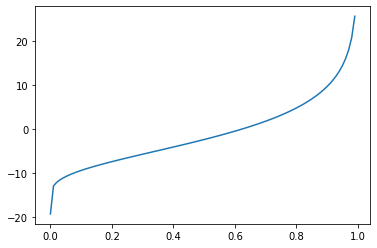

In [12]:
x=np.linspace(0,1,101)
plt.plot(x,f(x))

In [13]:
solution=fsolve(f,0.6)[0]  
solution                    

# This is F_S(T)(K) that needs to be solved from a non-linear equation given above.
# 0.6 is the initial guess of the function f(see the plot above)
# fsolve(f,0.6) returns an array(containing a single element in this case). solution grabs the entry from this array.

0.6245261442077039

In [14]:
k1=f1(solution)
k2=f2(solution)
k3=f3(solution)

In [15]:
d11=(np.log(S10/k1)+(r-delta1+(sigma1**2)/2)*T)/(sigma1*np.sqrt(T))
d12=d11-sigma1*np.sqrt(T)

d21=(np.log(S20/k2)+(r-delta2+(sigma2**2)/2)*T)/(sigma2*np.sqrt(T))
d22=d21-sigma2*np.sqrt(T)

d31=(np.log(S30/k3)+(r-delta3+(sigma3**2)/2)*T)/(sigma3*np.sqrt(T))
d32=d31-sigma3*np.sqrt(T)

In [16]:
component1=S10*np.exp(-delta1*T)*norm.cdf(d11)-k1*np.exp(-r*T)*norm.cdf(d12)
component2=S20*np.exp(-delta2*T)*norm.cdf(d21)-k2*np.exp(-r*T)*norm.cdf(d22)
component3=S30*np.exp(-delta3*T)*norm.cdf(d31)-k3*np.exp(-r*T)*norm.cdf(d32)

In [17]:
price2=a1*component1+a2*component2+a3*component3
price2

2.720340264340911

In [18]:
pricedifference=price1-price2
pricedifference

0      0.003135
1      0.001678
2     -0.040635
3     -0.008756
4     -0.015744
         ...   
995    0.020366
996   -0.013813
997    0.000020
998   -0.000438
999   -0.007511
Length: 1000, dtype: float64

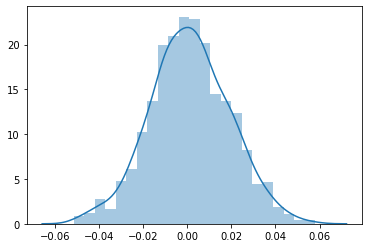

In [19]:
# The distribution of the error

sns.distplot(pricedifference)